In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib
import matplotlib.pyplot as plt
import datetime

import sklearn
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from src.data.make_dataset import process_data
from src.visualization.plots import make_fig, plot_sales, \
    show_timeseries_analysis, show_comparison_original_vs_restored
from tqdm.notebook import tqdm
import seaborn as sns
from src.features.make_model_dataset import get_x_y

# Loading the data

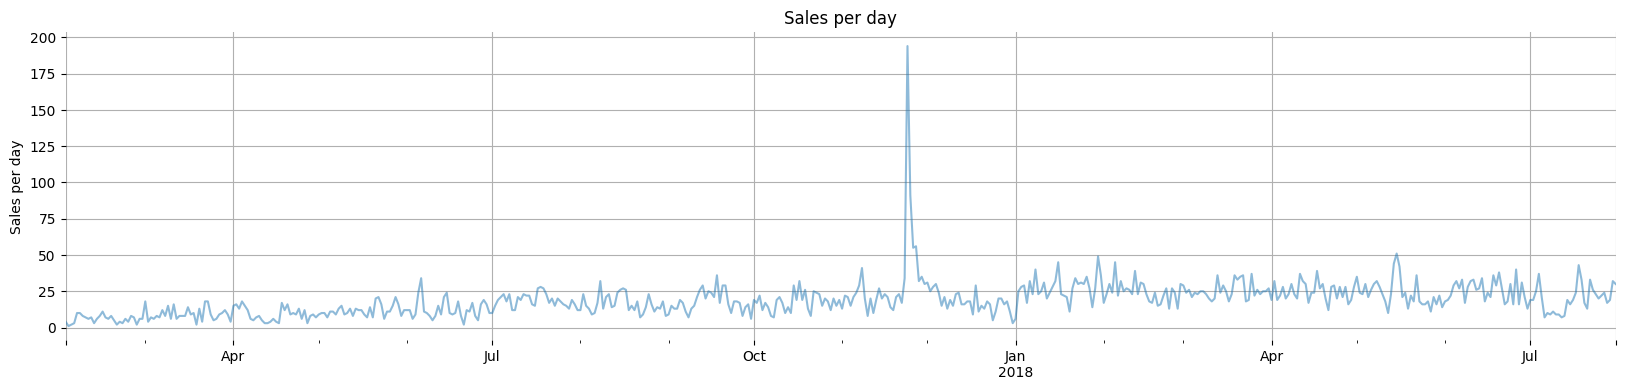

product_category_name,cama_mesa_banho
date,
2017-02-01,4.0
2017-02-02,1.0
2017-02-03,2.0


In [3]:
df_product_sales = process_data(datetime.datetime(2017, 2, 1), datetime.datetime(2018, 8, 1), num_top_products=1)
plot_sales(df_product_sales, title='Sales per day')
display(df_product_sales.head(3))

# Exploring the timeseries properties

Before using the timeseries for forecasting, we need to check it's properties:
* Distribution
* Whether mean and variance are stationary (autocorrelations, trend, seasonality)

In [4]:
# Transform the time series to the format more suitable for machine learning

df_data = df_product_sales.copy()
df_data.columns.rename(None, inplace=True)
df_data.rename(columns={df_data.columns[0]: 'x'}, inplace=True)
df_data.head(3)

,x
date,
2017-02-01,4.0
2017-02-02,1.0
2017-02-03,2.0


### Original timeseries

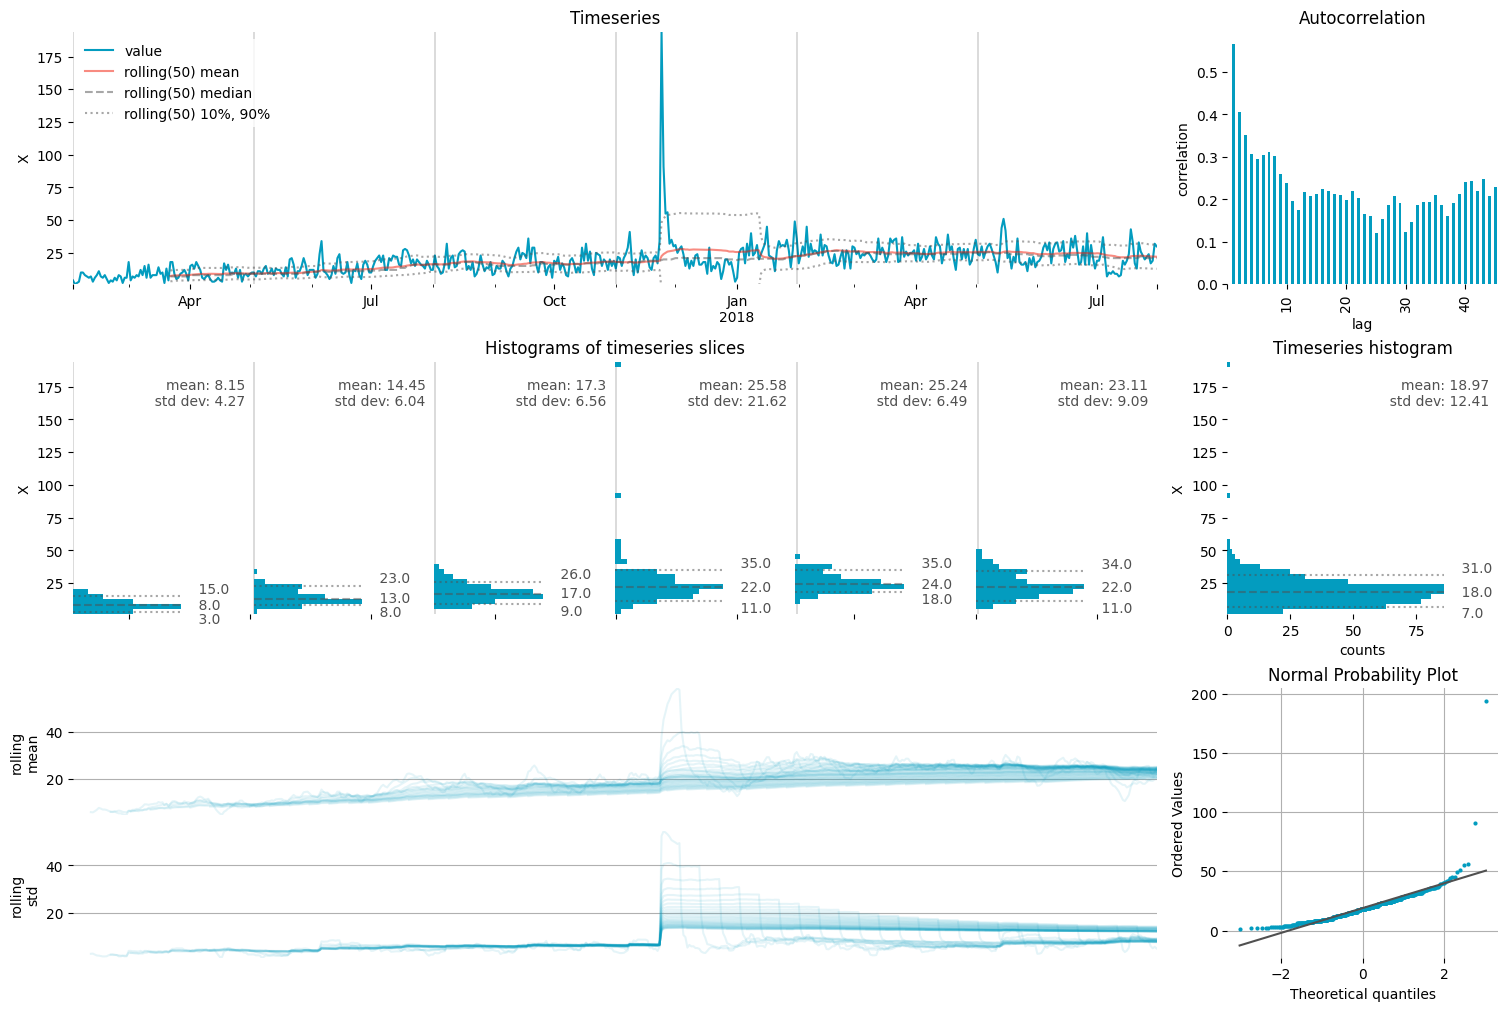

Shapiro-Wilk Results=====================================Test Statistic: 0.7138767941318096P-value: 1.758563651016774e-29-------------------------------------Conclusion: Not Gaussian,D’Agostino’s K^2 Results=====================================Test Statistic: 673.0317330362335P-value: 7.128794544271642e-147-------------------------------------Conclusion: Not Gaussian,Lilliefors Results=====================================Test Statistic: 0.10278954966982845P-value: 0.0009999999999998899-------------------------------------Conclusion: Not Gaussian
"Augmented Dickey-Fuller Results =====================================Test Statistic -4.840P-value 0.000Lags 6-------------------------------------Trend: ConstantCritical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)Null Hypothesis: The process contains a unit root.Alternative Hypothesis: The process is weakly stationary.","KPSS Stationarity Test Results =====================================Test Statistic 2.233P-value 0.000Lags 13-------------------------------------Trend: ConstantCritical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)Null Hypothesis: The process is weakly stationary.Alternative Hypothesis: The process contains a unit root.","Zivot-Andrews Results =====================================Test Statistic -10.063P-value 0.000Lags 2-------------------------------------Trend: ConstantCritical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)Null Hypothesis: The process contains a unit root with a single structural break.Alternative Hypothesis: The process is trend and break stationary."


In [5]:
show_timeseries_analysis(df_data['x'])

* Distribution is not Gausian
* Mean changes over time
* Variance changes over time
* High level of auto-correlations
* D’Agostino’s K Squared test indicates that series is not stationary

Conclusion: using timeseries as is would not be suitable for forecasting.  
Below few different transformations of the timeseries are tried in order to improve it's properties for the forecasting.

When transforming the timeseries, it is important to avoid the transformations that would rely on the future information (for example, using global average of standard deviation).

Also, transformation should be reversible i.e. it should be possible to restore the original timeseries from the transformed values and past values.

### First order differences

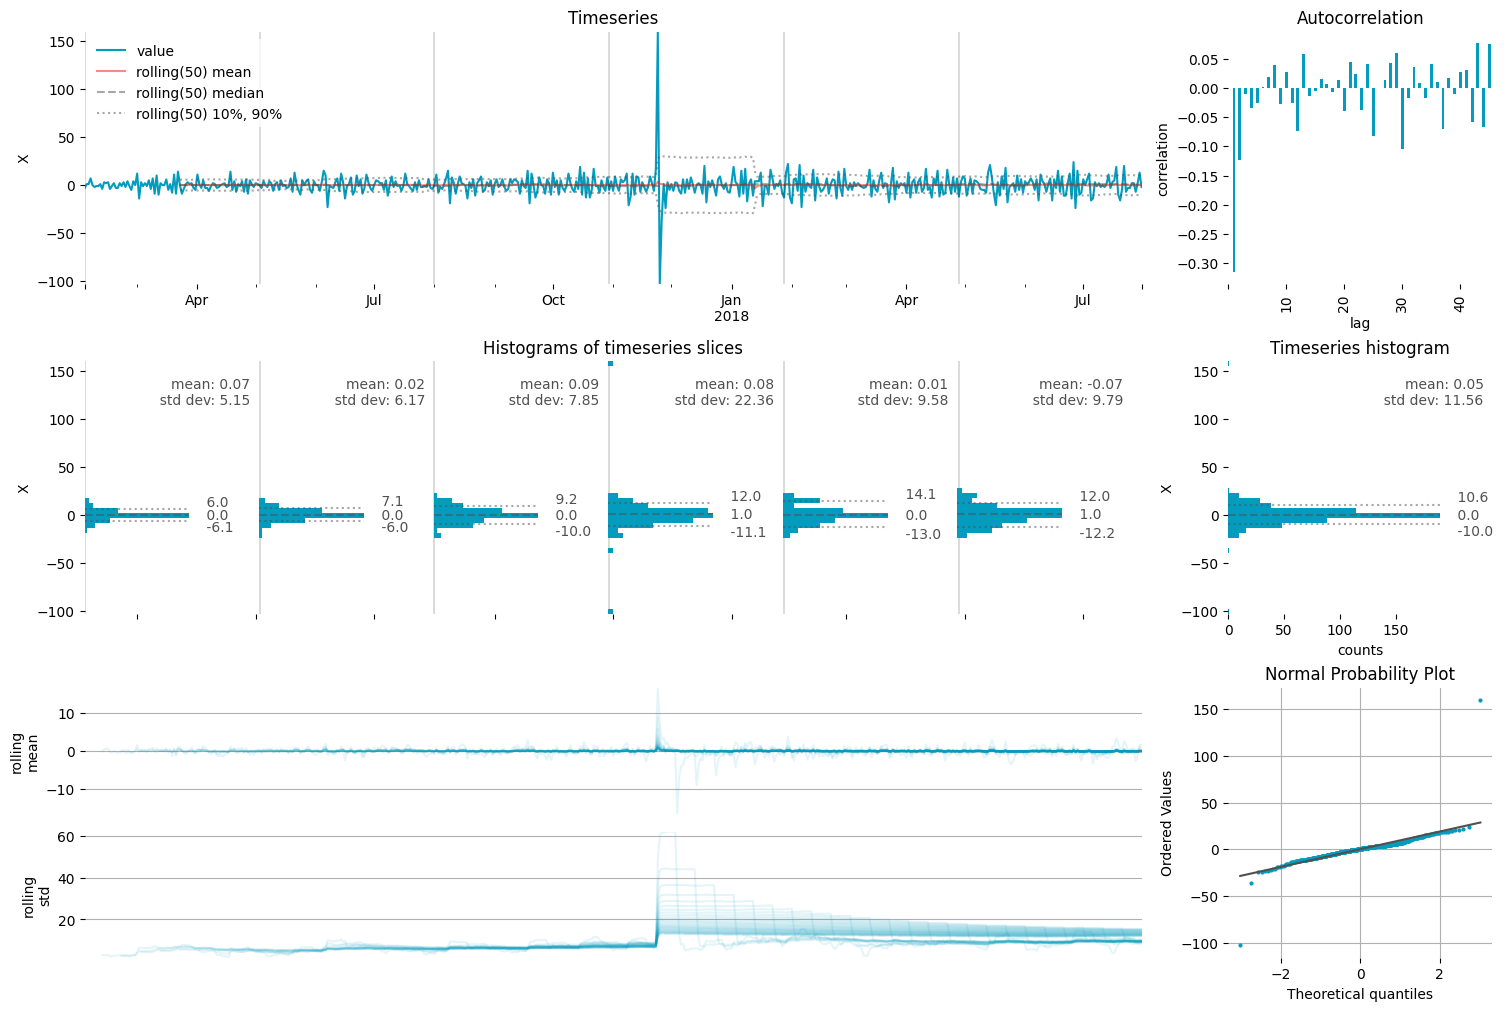

Shapiro-Wilk Results=====================================Test Statistic: 0.6816789237433349P-value: 9.829933857768765e-31-------------------------------------Conclusion: Not Gaussian,D’Agostino’s K^2 Results=====================================Test Statistic: 526.8082498024147P-value: 4.02756023992463e-115-------------------------------------Conclusion: Not Gaussian,Lilliefors Results=====================================Test Statistic: 0.13058456998441692P-value: 0.0009999999999998899-------------------------------------Conclusion: Not Gaussian
"Augmented Dickey-Fuller Results =====================================Test Statistic -13.995P-value 0.000Lags 6-------------------------------------Trend: ConstantCritical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)Null Hypothesis: The process contains a unit root.Alternative Hypothesis: The process is weakly stationary.","KPSS Stationarity Test Results =====================================Test Statistic 0.127P-value 0.470Lags 126-------------------------------------Trend: ConstantCritical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)Null Hypothesis: The process is weakly stationary.Alternative Hypothesis: The process contains a unit root.","Zivot-Andrews Results =====================================Test Statistic -14.281P-value 0.000Lags 6-------------------------------------Trend: ConstantCritical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)Null Hypothesis: The process contains a unit root with a single structural break.Alternative Hypothesis: The process is trend and break stationary."


In [6]:
show_timeseries_analysis(df_data['x'].diff())

* Distribution is not Gausian
* Mean stays near zero
* Variance still increases over time
* Low level of auto-correlations
* Tests show that the data is stationary.

### First order differences divided by the rolling standard deviation
Note: we are using the standard deviation from the previous N periods, not including the current day. This is needed in order to be able to perform the backward data transformation given the predicted values.

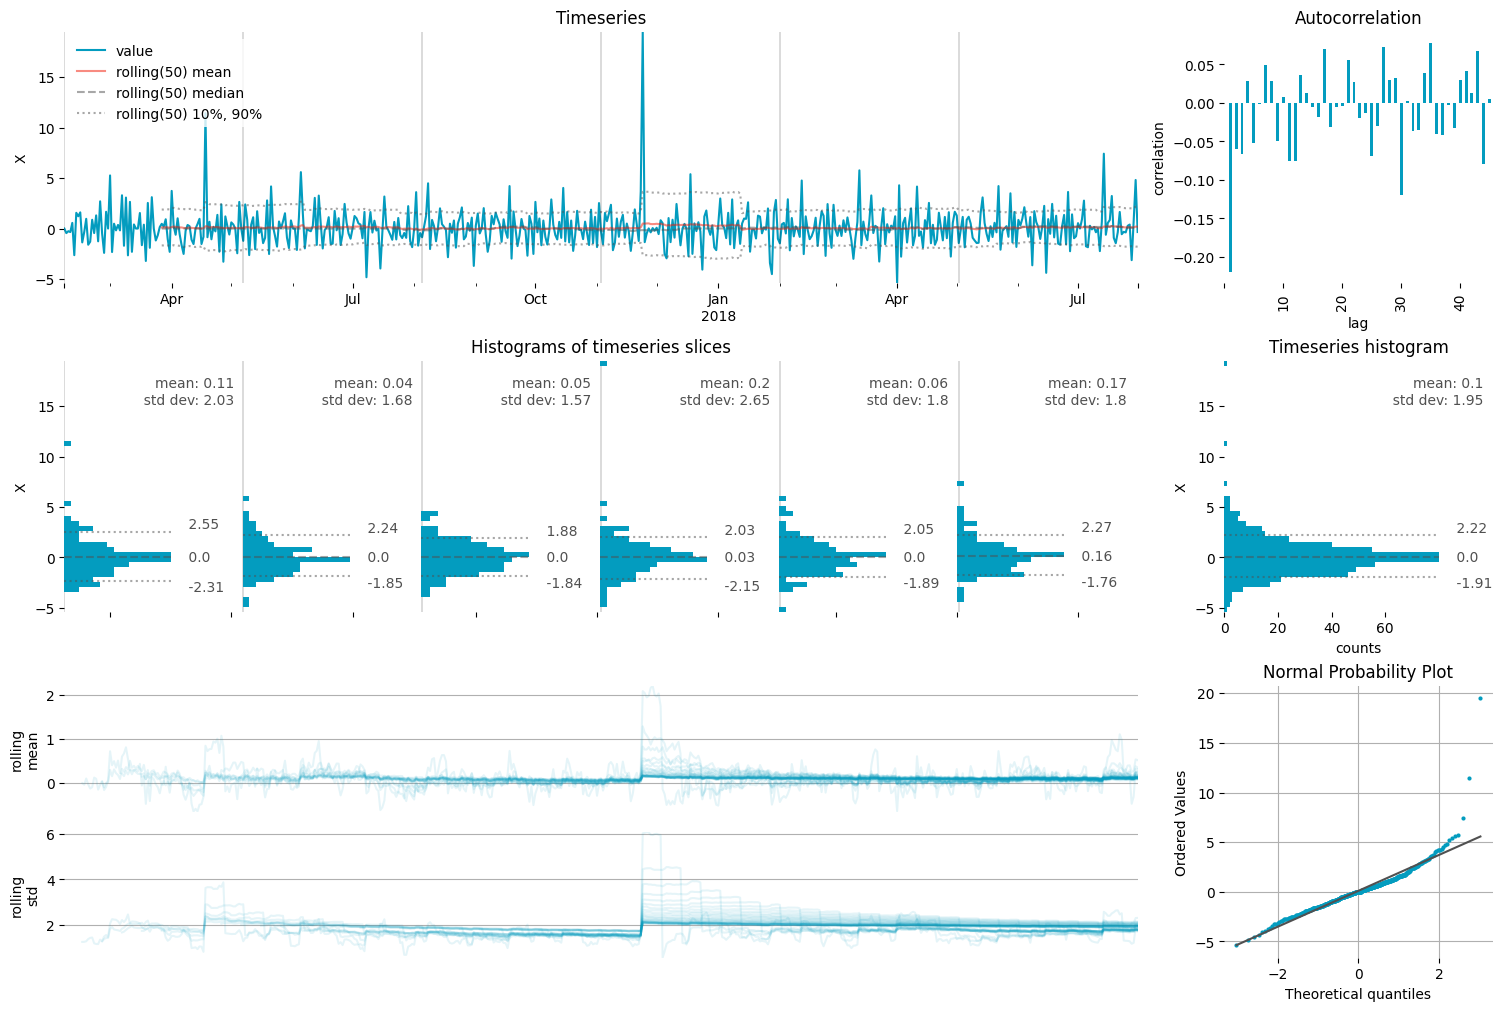

Shapiro-Wilk Results=====================================Test Statistic: 0.8691451144675888P-value: 6.942932833051758e-21-------------------------------------Conclusion: Not Gaussian,D’Agostino’s K^2 Results=====================================Test Statistic: 354.4695897390514P-value: 1.066366730047698e-77-------------------------------------Conclusion: Not Gaussian,Lilliefors Results=====================================Test Statistic: 0.09147098080845495P-value: 0.0009999999999998899-------------------------------------Conclusion: Not Gaussian
"Augmented Dickey-Fuller Results =====================================Test Statistic -16.958P-value 0.000Lags 2-------------------------------------Trend: ConstantCritical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)Null Hypothesis: The process contains a unit root.Alternative Hypothesis: The process is weakly stationary.","KPSS Stationarity Test Results =====================================Test Statistic 0.039P-value 0.936Lags 16-------------------------------------Trend: ConstantCritical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)Null Hypothesis: The process is weakly stationary.Alternative Hypothesis: The process contains a unit root.","Zivot-Andrews Results =====================================Test Statistic -17.085P-value 0.000Lags 2-------------------------------------Trend: ConstantCritical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)Null Hypothesis: The process contains a unit root with a single structural break.Alternative Hypothesis: The process is trend and break stationary."


In [7]:
sr_x = df_data['x']
num_rolling = 5
sr_x = sr_x.diff() / sr_x.shift(1).rolling(num_rolling).std()

show_timeseries_analysis(sr_x)

* Distribution is not Gausian
* Mean stays near zero
* Variance does not change over time
* Low level of auto-correlations
* Tests show that the data is stationary.

### Values with subtracted rolling average and divided by the rolling standard deviation

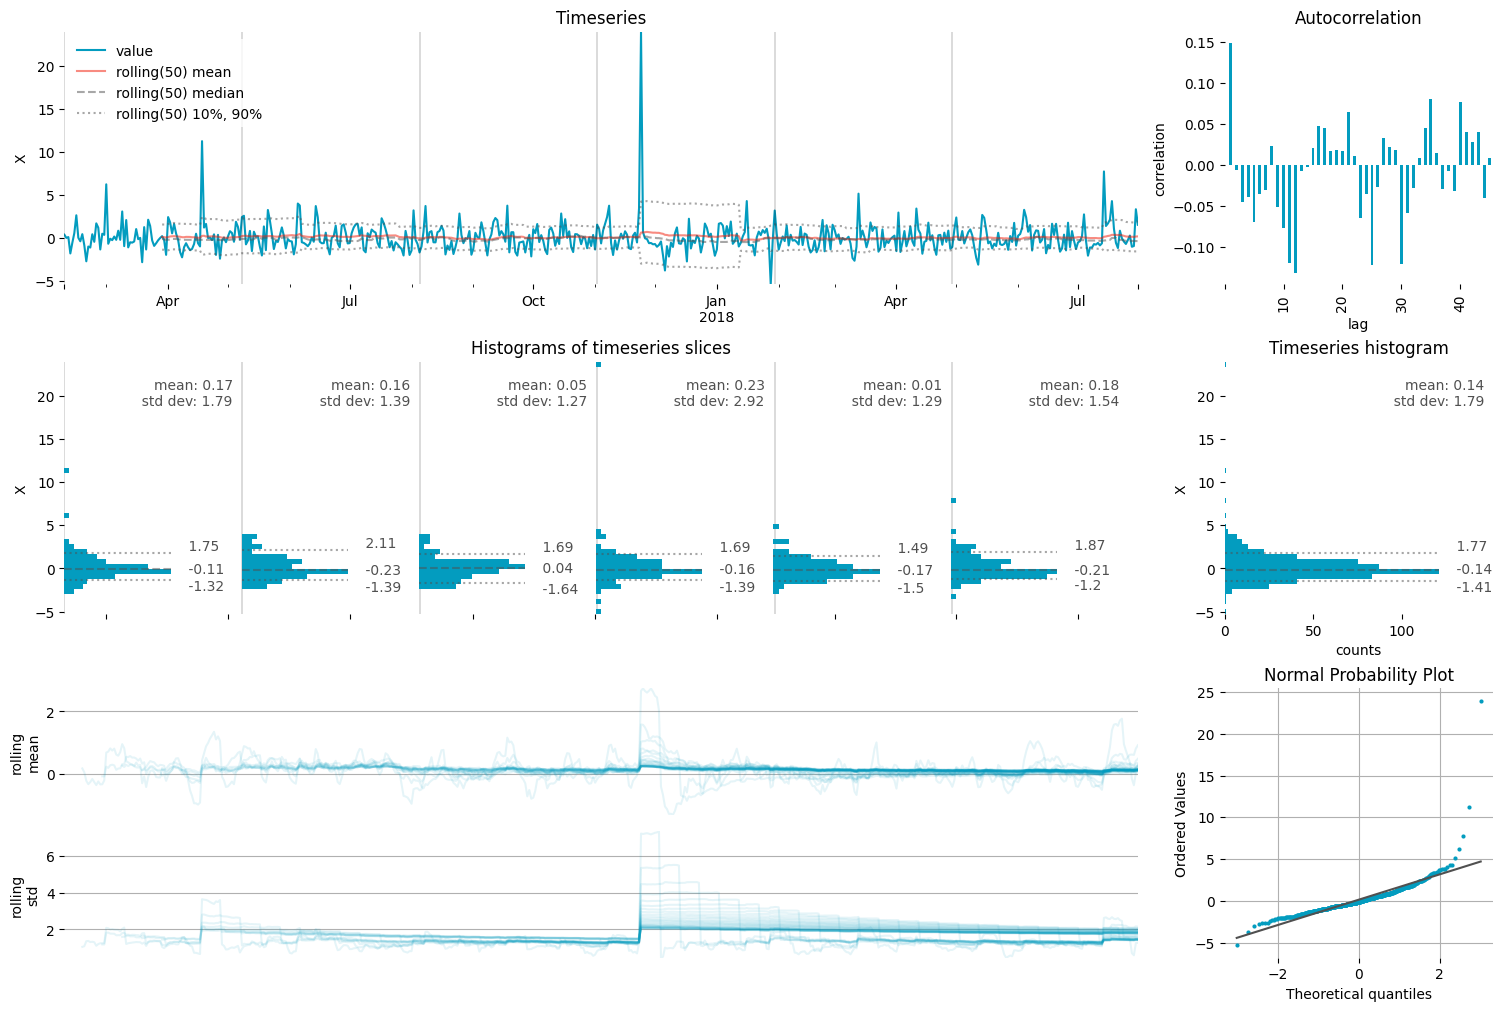

Shapiro-Wilk Results=====================================Test Statistic: 0.7226659569455578P-value: 6.044649435328718e-29-------------------------------------Conclusion: Not Gaussian,D’Agostino’s K^2 Results=====================================Test Statistic: 624.187156211571P-value: 2.88058829217615e-136-------------------------------------Conclusion: Not Gaussian,Lilliefors Results=====================================Test Statistic: 0.12106761286565804P-value: 0.0009999999999998899-------------------------------------Conclusion: Not Gaussian
"Augmented Dickey-Fuller Results =====================================Test Statistic -9.334P-value 0.000Lags 11-------------------------------------Trend: ConstantCritical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)Null Hypothesis: The process contains a unit root.Alternative Hypothesis: The process is weakly stationary.","KPSS Stationarity Test Results =====================================Test Statistic 0.026P-value 0.986Lags 3-------------------------------------Trend: ConstantCritical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)Null Hypothesis: The process is weakly stationary.Alternative Hypothesis: The process contains a unit root.","Zivot-Andrews Results =====================================Test Statistic -9.684P-value 0.000Lags 11-------------------------------------Trend: ConstantCritical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)Null Hypothesis: The process contains a unit root with a single structural break.Alternative Hypothesis: The process is trend and break stationary."


In [8]:
sr_x = df_data['x']
num_rolling = 7
sr_x = (sr_x - sr_x.shift(1).rolling(num_rolling).mean()) / sr_x.shift(1).rolling(num_rolling).std()

show_timeseries_analysis(sr_x)

* Distribution is not Gausian
* Mean stays near zero
* Variance does not change over time
* There are osciallting auto-correlations
* Tests mostly show that the data is stationary although Test Statistic in KPSS Test is lower than critical values.

# Selecting the best transformation
Considering the results above, we are going to proceed with **First order differences divided by the rolling standard deviation**.

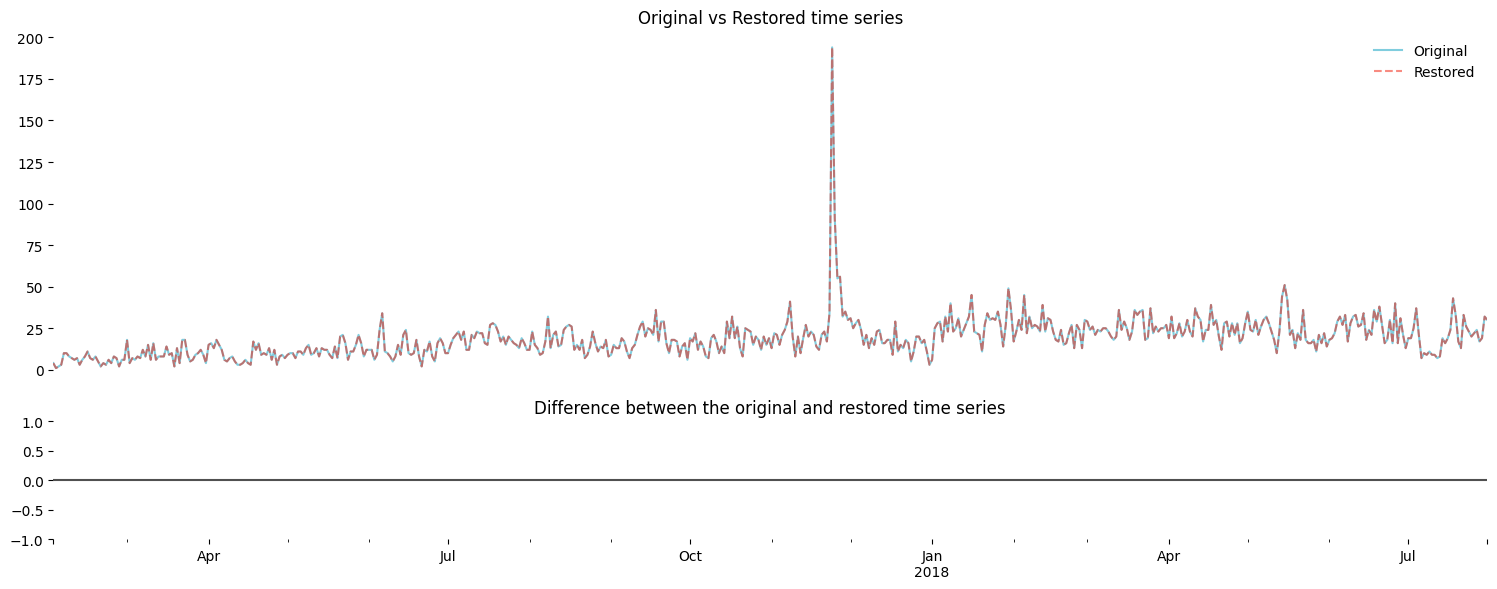

In [9]:
from src.features.timeseries_transform import TimeseriesTransformerDiffDividedByStd

num_rolling=5
timeseries_transformer = TimeseriesTransformerDiffDividedByStd(num_rolling=num_rolling)
show_comparison_original_vs_restored(
    df_data['x'], 
    timeseries_transformer)

# Creating the features and baseline predictions

Our assumed business goal is to forecast the next day sales.

We will use past values of the series for forecasting the next day value.
As shown above, the sales data needs to be transformed to be stationary. 
Then we can generate features based on this transformed data. Once model provides a prediction, we can transform it back to the expected sales value.

Variable x is our transformed data. Based on it we can generate lagged values.

In [10]:
from src.features.make_model_dataset import split_data_train_val_test
from src.features.make_model_dataset import create_augumented_data_for_model

validation_ratio = 0.1
test_ratio = validation_ratio

df_data_transformed = create_augumented_data_for_model(
    df_data, max_lag=9, target_shift=1,
    validation_ratio=validation_ratio,
    test_ratio=test_ratio,
    timeseries_transformer=timeseries_transformer,
    is_differenced=True,
    augument_with_periodic_phases=True,
    )
display(df_data_transformed.head(3))
df_train, df_val, df_test = split_data_train_val_test(df_data_transformed, validation_ratio, test_ratio)

for df in [df_train, df_val, df_test]:
    print(df.shape)

x                                                    \
                  -9        -8        -7        -6        -5        -4   
date                                                                     
2017-02-15  0.000000 -0.450606 -0.259938 -0.347105  0.559017 -2.637522   
2017-02-16 -0.450606 -0.259938 -0.347105  0.559017 -2.637522  1.559626   
2017-02-17 -0.259938 -0.347105  0.559017 -2.637522  1.559626  1.217161   

                                                           y          x  \
                  -3        -2        -1        -0         1 week_phase   
date                                                                      
2017-02-15  1.559626  1.217161  1.603567 -1.371989 -0.342997   0.285714   
2017-02-16  1.217161  1.603567 -1.371989 -0.342997  0.964486   0.428571   
2017-02-17  1.603567 -1.371989 -0.342997  0.964486 -1.603567   0.571429   

                       baseline                    
           month_phase    naive linear_regression  
date                                               
2017-02-15    0.451613      0.0          0.204384  
2017-02-16    0.483871      0.0          0.206953  
2017-02-17    0.516129      0.0         -0.190334

(424, 15)
(53, 15)
(54, 15)


# Creating the model

In [11]:
from lightgbm import LGBMRegressor

def create_fit_model(df_train, df_val, *args, **kwargs):
    model = LGBMRegressor(*args, **kwargs)

    df_X_train, df_y_train = get_x_y(df_train)
    df_X_val, df_y_val = get_x_y(df_val)

    model.fit(df_X_train, df_y_train)

    # print(f'score {model.score(df_X_train, df_y_train)}')

    yhat_train = model.predict(df_X_train)
    # print(f'train error {sklearn.metrics.mean_squared_error(yhat_train, df_y_train)}')

    yhat_val = model.predict(df_X_val)
    # print(f'val error {sklearn.metrics.mean_squared_error(yhat_val, df_y_val)}')

    train_error = sklearn.metrics.mean_squared_error(yhat_train, df_y_train)
    val_error = sklearn.metrics.mean_squared_error(yhat_val, df_y_val)

    return model, train_error, val_error

# Tuning the model

Since it's a small model, we can perform a simple grid search to find the best hyperparameters.

In [26]:
from sklearn.model_selection import ParameterGrid

class SilentLogger:
    def info(self, msg: str) -> None:
        pass

    def warning(self, msg: str) -> None:
        pass

import lightgbm
#quick hack to suppress the lightgbm logging that ignores verbose=-1
lightgbm.basic._LOGGER = SilentLogger()

param_grid_definition = {
   'min_data_in_bin': [1]+list(range(10, 201, 20)),
   'min_data_in_leaf': [1]+list(range(10, 201, 20)),
#    'lambda_l1': [0, 1, 5],
#    'lambda_l2': [0, 1, 5],
#    'max_bin': [50, 100, 255],
#    'max_depth': [3, 7, 13, -1],
#    'num_leaves': [7,15, 31, 70],
}

def create_fit_models_grid(param_grid_definition):
    lst_grid_params =  list(ParameterGrid(param_grid_definition))
    lst_grid_models = []

    for params in tqdm(lst_grid_params):
        model, train_error, val_error = create_fit_model(
            df_train, df_val, 
            objective='regression_l2', 
            num_iterations=1000, 
            learning_rate=0.01,
            verbose=-1,
            boosting_type = 'dart',
            **params
        )

        lst_grid_models.append({
            'model': model, 
            'train_error': train_error,
            'val_error': val_error})
        # clear_output(wait=True)    

    dict_grid_models = {}

    for i, p in enumerate(lst_grid_params):
        dict_grid_models[
            (p['min_data_in_bin'], p['min_data_in_leaf'])
        ] = lst_grid_models[i]

    print(f'{len(lst_grid_models)} models trained and validated')

    return lst_grid_params, dict_grid_models, lst_grid_models

lst_grid_params, dict_grid_models, lst_grid_models = create_fit_models_grid(param_grid_definition)

  0%|          | 0/121 [00:00<?, ?it/s]

121 models trained and validated


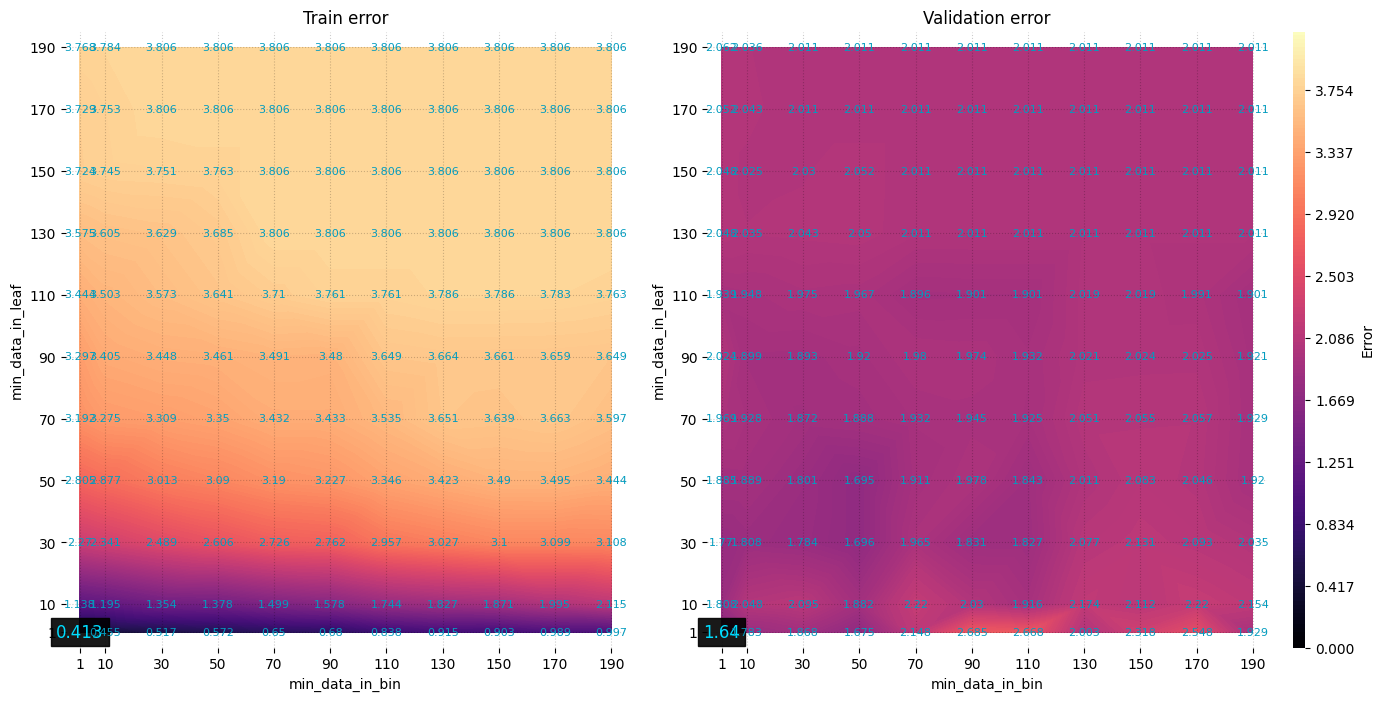

In [30]:
from src.visualization.plots import S, make_fig

def plot_ax_error_grid(ax, levels, x, y, z, x_spec, y_spec, title):
    cmap = sns.color_palette("magma", as_cmap=True)

    cs = ax.tricontourf(x, y, z, levels=levels, cmap=cmap)
    ax.set_xlabel('min_data_in_bin')
    ax.set_ylabel('min_data_in_leaf')



    min_x = None
    min_y = None
    color_base = S.neutral
    for i, z_item in enumerate(z):
        size = 8
    
        color = f'{color_base}ff'
        # color = f'{S.context}90'
        bbox_props = None
        if z_item <= z.min():
            
            color = '#00DDFF'
            back_color = '#000000'
            bbox_props = dict(boxstyle="Square", fc=back_color, ec=back_color, alpha=0.9)
            size = 12

            min_x = x[i]
            min_y = y[i]

        ax.text(x[i], y[i], np.round(z_item,3), 
                bbox=bbox_props,
                ha='center', va='center', fontdict={
                    'size': size, 
                    'color': color,
                    })
        
    # ax.axhline(y=min_y, color=color_base, linestyle='-', linewidth=0.5, alpha=0.4)
    # ax.axvline(x=min_x, color=color_base, linestyle='-', linewidth=0.5, alpha=0.4)

    # ax.scatter(min_x, min_y, c=color_base, marker='.')

    ax.set_xticks(x_spec)
    ax.set_yticks(y_spec)

    ax.set_xlim(x_spec[0]-5, x_spec[-1]+5)
    ax.set_ylim(y_spec[0]-5, y_spec[-1]+5)

    ax.set_title(title)
    ax.grid(True, linestyle=':', color='#00000020', alpha=0.2)

    return cs

def plot_error_grid(x, y, z_train, z_val, x_spec, y_spec):

    fig, axx = make_fig(18,8, ncols=3, 
                        gridspec_kw={'width_ratios': [1,1,0.2],
                                     'wspace':0.2
                                     },
                        )

    z = np.concatenate([z_val, z_train])

    zrange = z.max() - z.min()
    zpadding = 0.1 * zrange
    levels = np.linspace(0, z.max()+zpadding, 160)

    cs = plot_ax_error_grid(axx[0], levels, x, y, z_train, x_spec, y_spec, 'Train error')
    cs = plot_ax_error_grid(axx[1], levels, x, y, z_val, x_spec, y_spec, 'Validation error')

    ax = axx[2]
    ax.set_axis_off()
    
    cbar = fig.colorbar(cs, drawedges=False, 
                        aspect = 50, label='Error', ax=ax,
                        fraction=1.5)
    cbar.outline.set_visible(False)

    # fig.tight_layout()
    plt.show()


def show_model_errors_grid(
        lst_grid_params, 
        lst_grid_models,
        str_x_dimension,
        str_y_dimension):

    x = np.array([
        e[str_x_dimension] for e in lst_grid_params
    ])

    x_spec = param_grid_definition[str_x_dimension]

    y = np.array([
        e[str_y_dimension] for e in lst_grid_params
    ])

    y_spec = param_grid_definition[str_y_dimension]

    z_train = np.array([
        e['train_error'] for e in lst_grid_models
    ])
    z_val = np.array([
        e['val_error'] for e in lst_grid_models
    ])

    plot_error_grid(x, y, z_train, z_val, x_spec, y_spec)

show_model_errors_grid(
        lst_grid_params, 
        lst_grid_models,
        'min_data_in_bin',
        'min_data_in_leaf')

## Selecting the best model
Following criteria are used to select the best model:
* Only models with small differences between the train and validation errors are considered
* Among these models, the one with the smallest validation error is selected

In [31]:
df_grid_models = pd.DataFrame(dict_grid_models).T
df_grid_models['train_val_diff'] = (df_grid_models['train_error'] - df_grid_models['val_error']).abs()
df_grid_models['score'] =\
    -(df_grid_models['val_error'])

df_grid_models_filtered = df_grid_models[
    df_grid_models['train_val_diff'] <= df_grid_models['train_val_diff'].quantile(0.5)
]

best_model_spec = df_grid_models_filtered[
    df_grid_models_filtered['score'] == df_grid_models_filtered['score'].max()
]

best_model = best_model_spec['model'].iloc[0]
best_model_spec

,,model,train_error,val_error,train_val_diff,score
1,1,"LGBMRegressor(boosting_type='dart', learning_r...",0.413346,1.640153,1.226807,-1.640153


# Evaluating the model

### Using the training metric

First we can compare the model with the baseline using the same metric as during the training.
Here we measure the mean squared error (MSE) between the predicted transformed (i.e. normalised) values and the actual transformed values.

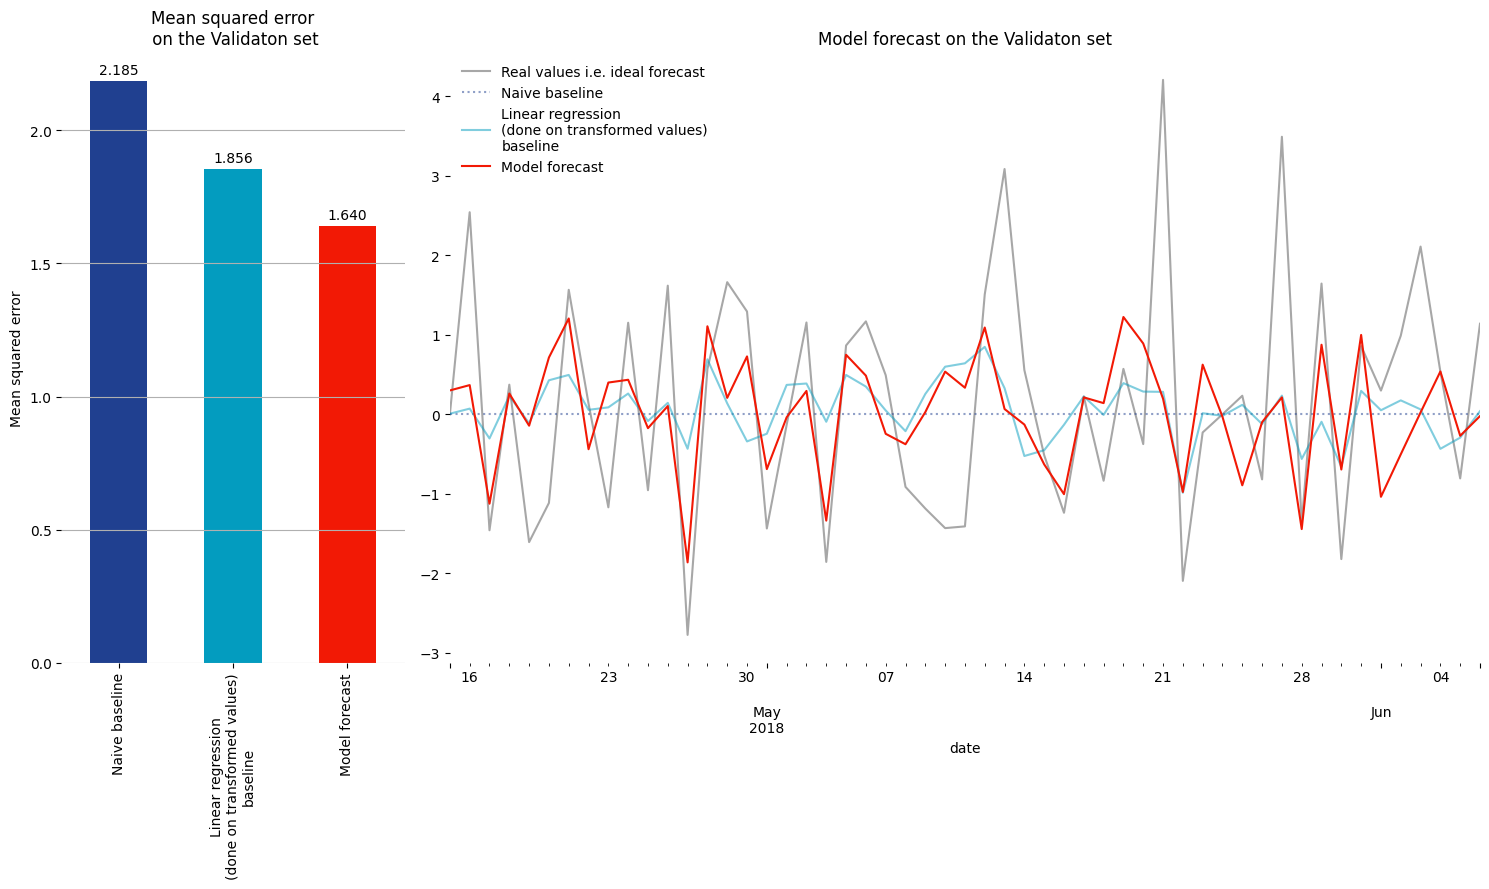

In [32]:
from src.visualization.plots import show_forecast_errors_and_predictions_transform_reversed,\
show_forecast_errors_and_predictions

show_forecast_errors_and_predictions(
    df_val, best_model, 
    (sklearn.metrics.mean_squared_error, 'Mean squared error'),
    'Validaton')

### Considering business goal

However we should keep the final goal in mind - predict the actual sales. So from the business point of view this model should be evaluated by comparing its sales forecasts (rather than normalised values forecasts) with the actual sales.

How exactly this comparison should be made, depends on the specific business challenges. If it's important to avoid especially large events of oversupply or undersupply then we can use the MSE (mean squared error) as the evaluation metric since it penalises large errors more than small ones.

If we are interested in the overall average oversupply/undersuply to be minimised (without special attention to oversupply/undersuply spikes) then we can use the MAE (mean absolute error) as the evaluation metric.

It is also possible to imagine an assymmetric goal where, for example, avoiding undersupply is more important than avoiding oversupply. In this case we can modify MAE or MSE so that different weights are used for the positive and negative differences.

Since we don't know about such preferences, we are going to stick to MAE between the predicted and actual sales as the most neutral evaluation metric.

Note: Considering this, it might be beneficial to re-train the model using MAE instead of MSE and check whether it results in better evaluation.

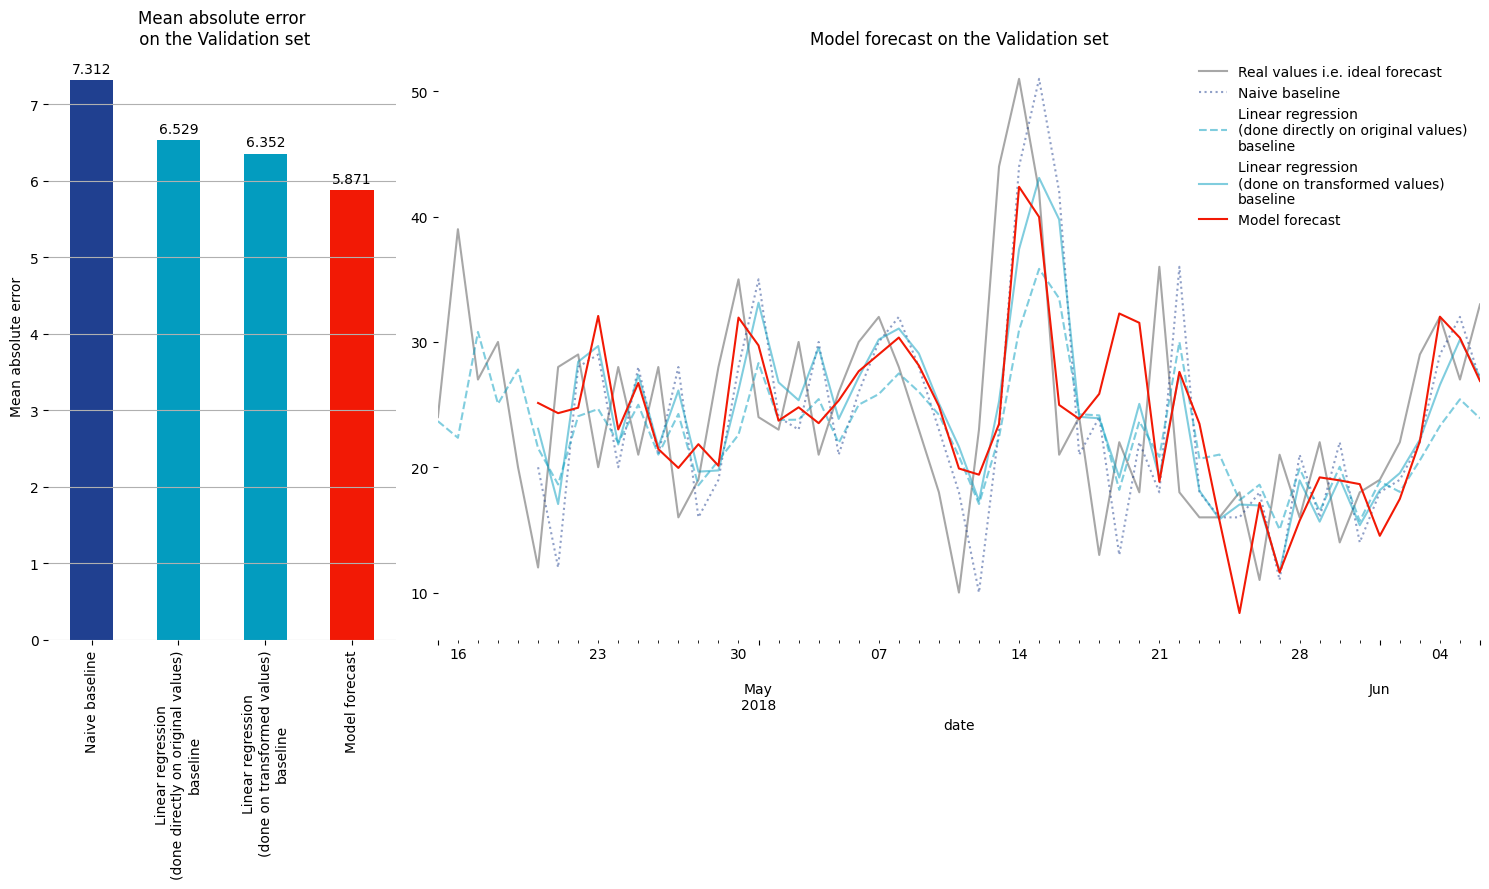

In [33]:
df_data_original = create_augumented_data_for_model(
    df_data, max_lag=9, target_shift=1,
    validation_ratio=validation_ratio,
    test_ratio=test_ratio,
    timeseries_transformer=None,
    is_differenced=False,
    augument_with_periodic_phases=True,
    )

df_train_original = df_data_original.loc[df_train.index]
df_val_original = df_data_original.loc[df_val.index]
df_test_original = df_data_original.loc[df_test.index]

from src.features.timeseries_transform import TimeseriesTransformerDiffDividedByStd

num_rolling=5
timeseries_transformer = TimeseriesTransformerDiffDividedByStd(num_rolling=num_rolling)

show_forecast_errors_and_predictions_transform_reversed(
    df_val, df_val_original, best_model,
    (sklearn.metrics.mean_absolute_error, 'Mean absolute error'), 
    timeseries_transformer,
    'Validation')

In [41]:
# !pip3 freeze > ../requirements.txt